# Subsystem 1 — Category-Level Supervised Model
Clean training notebook (train/validation/test split, 3-model comparison, ROC/PR on validation, threshold tuning on validation, final test once, and saving artifacts).

In [ ]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.metrics import (
    roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix,
    roc_curve, auc, precision_recall_curve, average_precision_score
)
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.base import clone
import joblib

RANDOM_STATE = 42
TRAIN_RATIO = 0.60
VAL_RATIO = 0.20  # remaining 0.20 is test


In [ ]:
# 1) Load rolling supervised dataset
df = pd.read_csv("rolling_supervised_dataset.csv")

# Remove duplicate columns if any (e.g., duplicate CategoryName)
df = df.loc[:, ~df.columns.duplicated()].copy()

df.head()

,CategoryName,window_start,window_end,future_start,future_end,cur_mean,cur_sum,cur_std,coverage,volatility_ratio,intra_growth,target_up
0,Storage,2013-06-21,2013-07-18,2013-07-19,2013-08-15,4.25,119.0,22.083648,0.035714,5.196151,-1.0,0
1,Storage,2013-06-28,2013-07-25,2013-07-26,2013-08-22,0.00,0.0,0.000000,0.000000,0.000000,0.0,0
2,Storage,2013-07-05,2013-08-01,2013-08-02,2013-08-29,0.00,0.0,0.000000,0.000000,0.000000,0.0,0
3,Storage,2013-07-12,2013-08-08,2013-08-09,2013-09-05,0.00,0.0,0.000000,0.000000,0.000000,0.0,0
4,Storage,2013-07-19,2013-08-15,2013-08-16,2013-09-12,0.00,0.0,0.000000,0.000000,0.000000,0.0,0


## Feature preparation (no timestamp leakage)
- Keep raw date columns for tracking only (meta)
- Extract safe calendar features from `window_end` (month/week/day)
- Do **not** convert timestamps to int64 and do **not** use `future_*` columns as features

In [ ]:
# 2) Basic cleanup
# Drop highly correlated cur_sum 
if "cur_sum" in df.columns:
    df = df.drop(columns=["cur_sum"])

# Parse date columns (datetime for meta / feature extraction)
date_cols = ["window_start", "window_end", "future_start", "future_end"]
for c in date_cols:
    if c in df.columns:
        df[c] = pd.to_datetime(df[c], errors="coerce")

# Sort by time for time-based split
df = df.sort_values("window_start").reset_index(drop=True)

# Safe calendar features from window_end 
df["month"] = df["window_end"].dt.month
df["week_of_year"] = df["window_end"].dt.isocalendar().week.astype(int)
df["day_of_week"] = df["window_end"].dt.dayofweek

# Meta columns kept only for tracking/debugging 
meta_cols = [c for c in ["CategoryName","window_start","window_end","future_start","future_end"] if c in df.columns]
meta = df[meta_cols].copy()

# Build X/y
y = df["target_up"].astype(int)

# Drop target + raw date columns from X (prevents timestamp leakage)
drop_from_X = [c for c in ["target_up"] + date_cols if c in df.columns]
X = df.drop(columns=drop_from_X)

print("X columns:", list(X.columns))
print("Rows:", len(df), "Positive rate:", round(y.mean(), 4))


X columns: ['CategoryName', 'cur_mean', 'cur_std', 'coverage', 'volatility_ratio', 'intra_growth', 'month', 'week_of_year', 'day_of_week']
Rows: 1100 Positive rate: 0.2027


## Time-based split (Train/Val/Test)
Train = earliest 60%, Validation = next 20%, Test = latest 20%.

In [4]:
# 3) Time-based split
n = len(df)
train_end = int(n * TRAIN_RATIO)
val_end = int(n * (TRAIN_RATIO + VAL_RATIO))

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_val, y_val     = X.iloc[train_end:val_end], y.iloc[train_end:val_end]
X_test, y_test   = X.iloc[val_end:], y.iloc[val_end:]

print(f"Train size: {len(X_train)}  | Positive rate: {y_train.mean():.3f}")
print(f"Val size:   {len(X_val)}    | Positive rate: {y_val.mean():.3f}")
print(f"Test size:  {len(X_test)}   | Positive rate: {y_test.mean():.3f}")


Train size: 660  | Positive rate: 0.088
Val size:   220    | Positive rate: 0.405
Test size:  220   | Positive rate: 0.345


## Preprocessing
If `CategoryName` exists in X, it will be one-hot encoded. All other columns pass through.

In [ ]:
# 4) Preprocessing 
categorical_features = ["CategoryName"] if "CategoryName" in X.columns else []
numeric_features = [c for c in X.columns if c not in categorical_features]

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numeric_features)
    ],
    remainder="drop"
)


## Model comparison (Validation only)
We train 3 models on TRAIN and compare on VALIDATION.
Models:
- Logistic Regression (balanced)
- Random Forest (balanced)
- Gradient Boosting (no class_weight parameter)

In [6]:
# 5) Define 3 models
models = {
    "LogisticRegression_balanced": LogisticRegression(max_iter=2000, class_weight="balanced"),
    "RandomForest_balanced": RandomForestClassifier(n_estimators=300, class_weight="balanced", random_state=RANDOM_STATE),
    "GradientBoosting": GradientBoostingClassifier(random_state=RANDOM_STATE)
}

validation_results = []
pipelines = {}

# 6) Train on TRAIN, evaluate on VALIDATION
for name, model in models.items():
    pipe = Pipeline([
        ("preprocessor", preprocessor),
        ("model", model)
    ])
    pipe.fit(X_train, y_train)

    val_pred = pipe.predict(X_val)
    val_proba = pipe.predict_proba(X_val)[:, 1]

    metrics = {
        "Model": name,
        "ROC_AUC": roc_auc_score(y_val, val_proba),
        "F1": f1_score(y_val, val_pred, zero_division=0),
        "Precision": precision_score(y_val, val_pred, zero_division=0),
        "Recall": recall_score(y_val, val_pred, zero_division=0),
    }
    validation_results.append(metrics)
    pipelines[name] = pipe

    print("\n==============================")
    print(f"Validation Results - {name}")
    print("==============================")
    print("Confusion Matrix:\n", confusion_matrix(y_val, val_pred))
    for k in ["ROC_AUC","F1","Precision","Recall"]:
        print(f"{k}: {metrics[k]:.4f}")

val_df = pd.DataFrame(validation_results).sort_values("ROC_AUC", ascending=False)
print("\n==============================")
print("VALIDATION MODEL COMPARISON (sorted by ROC_AUC)")
print("==============================")
print(val_df)

best_model_name = val_df.iloc[0]["Model"]
best_pipeline = pipelines[best_model_name]
print("\nSelected Best Model:", best_model_name)



Validation Results - LogisticRegression_balanced
Confusion Matrix:
 [[98 33]
 [41 48]]
ROC_AUC: 0.6748
F1: 0.5647
Precision: 0.5926
Recall: 0.5393

Validation Results - RandomForest_balanced
Confusion Matrix:
 [[121  10]
 [ 82   7]]
ROC_AUC: 0.4681
F1: 0.1321
Precision: 0.4118
Recall: 0.0787

Validation Results - GradientBoosting
Confusion Matrix:
 [[131   0]
 [ 89   0]]
ROC_AUC: 0.5136
F1: 0.0000
Precision: 0.0000
Recall: 0.0000

VALIDATION MODEL COMPARISON (sorted by ROC_AUC)
                         Model   ROC_AUC        F1  Precision    Recall
0  LogisticRegression_balanced  0.674758  0.564706   0.592593  0.539326
2             GradientBoosting  0.513595  0.000000   0.000000  0.000000
1        RandomForest_balanced  0.468050  0.132075   0.411765  0.078652

Selected Best Model: LogisticRegression_balanced


## ROC + Precision–Recall curves (Validation)
Curves are plotted on VALIDATION using a model fitted on TRAIN.

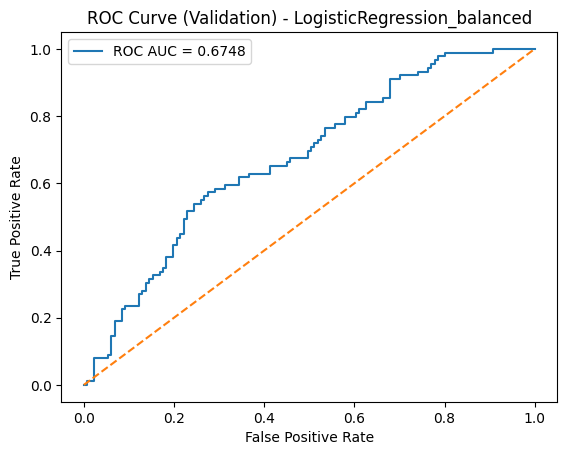

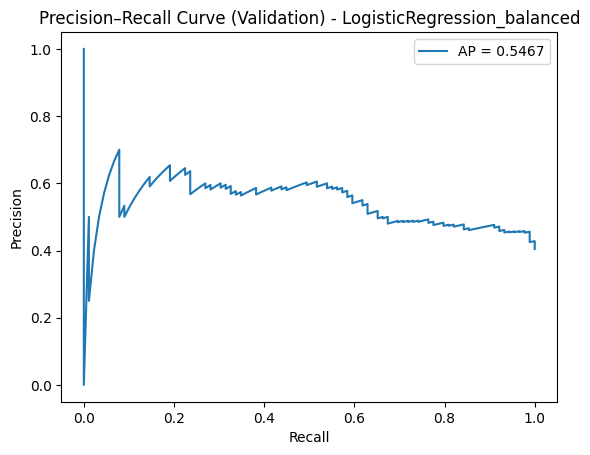

Validation ROC-AUC (prob-based): 0.6748
Validation Average Precision (AP): 0.5467


In [7]:
# 7) ROC + PR curves on validation (fit on TRAIN only)
best_for_curves = clone(best_pipeline)
best_for_curves.fit(X_train, y_train)
val_proba = best_for_curves.predict_proba(X_val)[:, 1]

# ROC
fpr, tpr, _ = roc_curve(y_val, val_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc_val:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title(f"ROC Curve (Validation) - {best_model_name}")
plt.legend()
plt.show()

# Precision-Recall
prec, rec, _ = precision_recall_curve(y_val, val_proba)
ap = average_precision_score(y_val, val_proba)

plt.figure()
plt.plot(rec, prec, label=f"AP = {ap:.4f}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title(f"Precision–Recall Curve (Validation) - {best_model_name}")
plt.legend()
plt.show()

print("Validation ROC-AUC (prob-based):", round(roc_auc_score(y_val, val_proba), 4))
print("Validation Average Precision (AP):", round(ap, 4))


## Threshold tuning (Validation)
We tune the classification threshold on VALIDATION (default is 0.5).

In [8]:
# 8) Threshold tuning on validation (optimize F1)
thresholds = np.arange(0.05, 0.96, 0.01)

rows = []
for t in thresholds:
    pred = (val_proba >= t).astype(int)
    rows.append({
        "threshold": float(t),
        "f1": f1_score(y_val, pred, zero_division=0),
        "precision": precision_score(y_val, pred, zero_division=0),
        "recall": recall_score(y_val, pred, zero_division=0),
    })

tune_df = pd.DataFrame(rows).sort_values("f1", ascending=False)
best_t = float(tune_df.iloc[0]["threshold"])

print("Best threshold (by F1 on validation):", best_t)
tune_df.head(10)


Best threshold (by F1 on validation): 0.09000000000000001


,threshold,f1,precision,recall
4,0.09,0.625483,0.476471,0.910112
5,0.10,0.625483,0.476471,0.910112
1,0.06,0.623574,0.471264,0.921348
3,0.08,0.623077,0.473684,0.910112
2,0.07,0.620690,0.470930,0.910112
0,0.05,0.616541,0.463277,0.921348
6,0.11,0.614786,0.470238,0.887640
7,0.12,0.614786,0.470238,0.887640
16,0.21,0.609756,0.477707,0.842697
15,0.20,0.604839,0.471698,0.842697


In [9]:
# Validation metrics at tuned threshold
val_pred_best = (val_proba >= best_t).astype(int)
print("Validation Confusion Matrix (tuned threshold):\n", confusion_matrix(y_val, val_pred_best))
print("Validation F1:", round(f1_score(y_val, val_pred_best, zero_division=0), 4))
print("Validation Precision:", round(precision_score(y_val, val_pred_best, zero_division=0), 4))
print("Validation Recall:", round(recall_score(y_val, val_pred_best, zero_division=0), 4))


Validation Confusion Matrix (tuned threshold):
 [[42 89]
 [ 8 81]]
Validation F1: 0.6255
Validation Precision: 0.4765
Validation Recall: 0.9101


## Final test evaluation (once)
Freeze: best model + tuned threshold. Retrain on TRAIN+VAL, evaluate on TEST.

In [ ]:
# 9) Final test evaluation (retrain on TRAIN+VAL)
X_train_full = pd.concat([X_train, X_val], axis=0)
y_train_full = pd.concat([y_train, y_val], axis=0)

final_model = clone(best_pipeline)
final_model.fit(X_train_full, y_train_full)

test_proba = final_model.predict_proba(X_test)[:, 1]

# Default threshold 0.5
test_pred_05 = (test_proba >= 0.5).astype(int)

# Tuned threshold best_t
test_pred_tuned = (test_proba >= best_t).astype(int)

print("=== TEST @ threshold 0.5 ===")
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred_05))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba), 4))
print("F1:", round(f1_score(y_test, test_pred_05, zero_division=0), 4))
print("Precision:", round(precision_score(y_test, test_pred_05, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, test_pred_05, zero_division=0), 4))

print("\n=== TEST @ tuned threshold ===")
print("Threshold:", best_t)
print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred_tuned))
print("ROC-AUC:", round(roc_auc_score(y_test, test_proba), 4))
print("F1:", round(f1_score(y_test, test_pred_tuned, zero_division=0), 4))
print("Precision:", round(precision_score(y_test, test_pred_tuned, zero_division=0), 4))
print("Recall:", round(recall_score(y_test, test_pred_tuned, zero_division=0), 4))


=== TEST @ threshold 0.5 ===
Confusion Matrix:
 [[72 72]
 [31 45]]
ROC-AUC: 0.5866
F1: 0.4663
Precision: 0.3846
Recall: 0.5921

=== TEST @ tuned threshold ===
Threshold: 0.09000000000000001
Confusion Matrix:
 [[  8 136]
 [  0  76]]
ROC-AUC: 0.5866
F1: 0.5278
Precision: 0.3585
Recall: 1.0


## Save artifacts
Save **model + tuned threshold** together so the allocation notebook can load one file.

In [11]:
# 10) Save artifacts (model + threshold)
artifacts = {
    "model": final_model,          # trained on TRAIN+VAL
    "threshold": float(best_t),    # tuned on VAL
    "feature_columns": list(X.columns),
    "best_model_name": best_model_name
}

joblib.dump(artifacts, "subsystem1_artifacts.pkl")
print("Saved: subsystem1_artifacts.pkl")

# (Optional) also save model-only for convenience
joblib.dump(final_model, "subsystem1_best_model.pkl")
print("Saved: subsystem1_best_model.pkl")


Saved: subsystem1_artifacts.pkl
Saved: subsystem1_best_model.pkl
